In [8]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, medfilt
import plotly
pd.options.plotting.backend = "plotly"

In [54]:
dataset = {
    "age24H1":("age24Jan52022.csv",14400,17000, "Healthy" , 4943, True),
    "age24H2":("age24Jan102022.csv",14400,17000, "Healthy", 4783, True),
    "age53H3":("age53Dec292021.csv",14400,17000, "Healthy", 7560, True),
#     "age21H4":("age21Jan52022.csv",21000,23600, "Healthy" , 5116, True),
    "age26H4":("age26Feb062022.csv",14400,17000, "Healthy", 4979, True),
    "age24H5":("age24Feb82022.csv",14400,17000, "Healthy" , 5050, True), # young diabetic
    
    "age55D3":("age55Jan102022.csv",14400,17000, "Diabetic", 4956, True),
#     "age60D1":("ageChandraniAmarasinghe.csv",1000,3600, "Diabetic", 5250, True),
    "age61D2":("ageUManaliAmarasinghe.csv",14400,17000, "Diabetic", 5624, True),
    "age66D4":("age66March62022.csv",14400,17000, "Diabetic", 5288, False),
    "age52D4":("age52Feb152022.csv",14400,17000, "Diabetic" , 5721, True) # 5050
}

# PAT Plots

In [24]:
def smoothing_filt(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(data, kernel, mode='same')
    return pd.DataFrame(data_convolved)

def filt(raw_signal, fs):
# raw_signal = PPG_D1
    # clean
    mean_sig = np.mean(raw_signal)
    raw_signal.where(raw_signal <= mean_sig*2, mean_sig, inplace=True)
    
# Lowpass filtering
    A_low = 100
    delt_w_low = 7.21 - 3.8
    M_low = (A_low-8)/(2.285*delt_w_low)
    order_low = 40
    fc_low = 8

    b_low = signal.firwin(order_low, fc_low, window=('kaiser', M_low), fs=fs) 
    filtered_low = filtfilt(b_low, 1, raw_signal)
    
    return filtered_low

In [11]:
def detrend(data):
    # data should be larger than 20,000 and have shape (20000,)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.linspace(10000,20000,10000),data[10000:20000])
    l = len(data)
    a2 =0
    x = np.linspace(0,l,l)
    leakage = x*a2 + x*slope + intercept
    return data-leakage


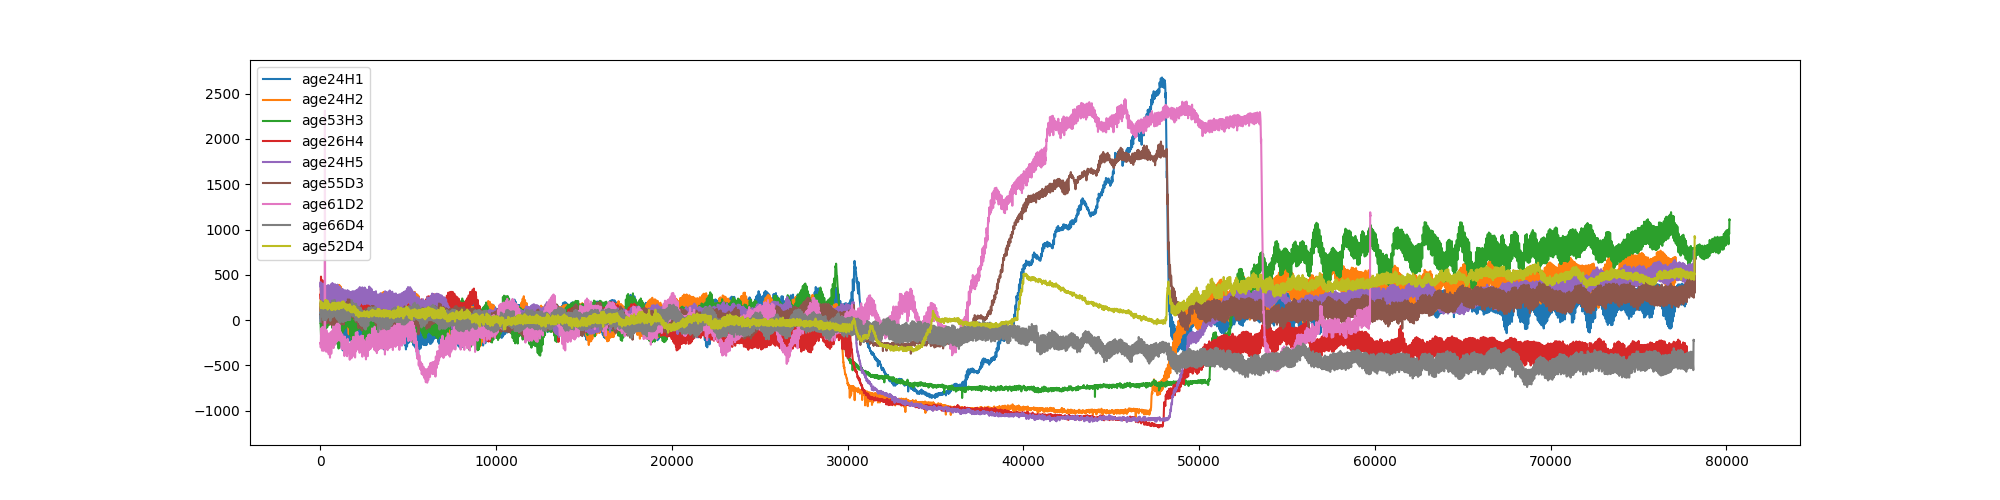

In [73]:
pat ={}
pat_filt ={}
ppg_seg = {}
avg_pulse_ppg = {}
ppg_indices = {}
fs = 100

plt.clf()
plt.cla()
plt.close()
plt.rcParams["figure.figsize"] = (20,5)
for patient,data in dataset.items():
    dataframe = pd.read_csv("Data/"+data[0])
    pat[patient] = dataframe["PData"]
#     smoothed = smoothing_filt(ppg[patient], 100)
#     mean_removed = smoothed - np.average(smoothed.dropna())
    offset = 0
    if(patient == 'age53H3'):
        offset = 22000
    
    pat_filt[patient] = filt(dataframe["PData"][offset:],fs)
    pat_filtC = filt(dataframe["PCData"][offset:],fs)
    
    pat_detrend = detrend(pat_filt[patient])
    pat_detrendC = detrend(pat_filtC)
    
    plt.plot(pat_detrend)
#     plt.plot(pat_detrendC)
#     plt.plot(pat_detrend- pat_detrendC)
#     plt.plot(leakage)
#     ppg_seg[patient] = filtered_ppg[patient][2][data[1]:data[2]]
#     avg_pulse_ppg[patient] = np.mean(get_pulses(ppg_seg[patient]), axis=0)
#     ppg_indices[patient] = pulse_indices(avg_pulse_ppg[patient])
#     print(f"ppg_indices['{patient}'] ={ppg_indices[patient]}")
#     plt.plot(avg_pulse_ppg[patient])
    
plt.legend(dataset.keys())
plt.show()

# Pulse Amplitude Plots
The PAT plots shown above show the variation of pressure in the cuff. However, we are more interested in the variation of the arterial pressure through out the experiment. Therefore, we shall observe the variation of Pulse Amplitudes

In [12]:
def get_pulses(data):
    neg_peaks, _ = signal.find_peaks(-data, distance=60)
    avg_pulse_len = np.mean(np.diff(neg_peaks)) 

    pulses = []
    for i in range(len(neg_peaks)-1):
        pulse = np.zeros(int(avg_pulse_len*1.2))
        p_len = neg_peaks[i+1]-neg_peaks[i]
        
        if (p_len<avg_pulse_len*1.2)&(p_len>avg_pulse_len*0.8):
            p = data[neg_peaks[i]:neg_peaks[i+1]]
            pulse[:p_len] = p #- min(p)
            
            pulse_loc = neg_peaks[i]
            pulses.append((max(p)-p[0], pulse_loc,pulse))
            # plt.plot(pulse)
            
    # plt.show()
    return pulses
def get_pulse_amplitudes(data):
    pulse_peaks= []
    pulse_amplitudes= []

    pulses = get_pulses(data)
    for pulse in pulses:
        pulse_amplitudes.append(pulse[0])
        pulse_peaks.append(pulse[1])
    
#     plt.plot(pat_detrend)
#     plt.plot(pulse_peaks,pulse_amplitudesM)
#     plt.plot()

    # interpolate
    interp_func = interp1d(pulse_peaks, pulse_amplitudes)
    x = np.linspace(pulse_peaks[0],pulse_peaks[-1],pulse_peaks[-1])
    y = interp_func(x)
    return y

In [62]:
def shift(data, align_point):
    result = data[align_point-15000: min(align_point+50000,len(data))]
    return result

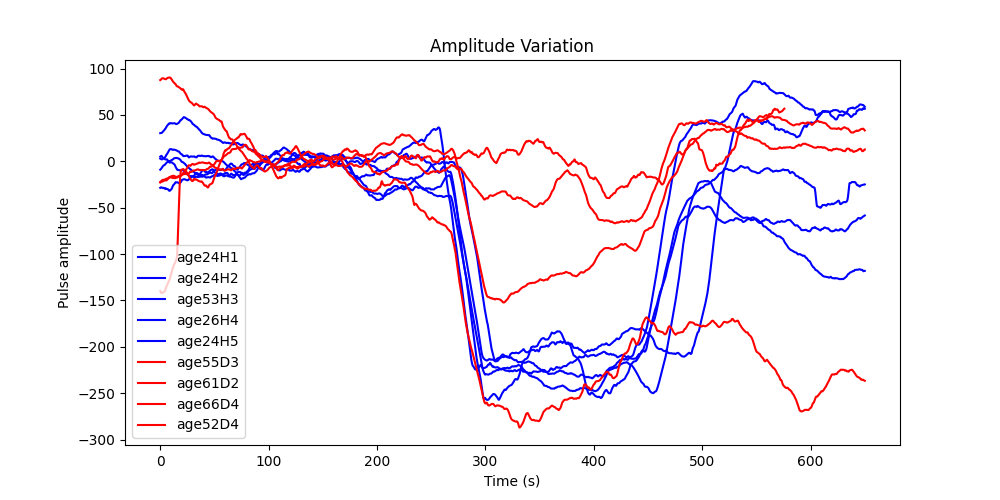

In [72]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import uniform_filter1d

pat ={}
pat_filt ={}
ppg_seg = {}
avg_pulse_ppg = {}
ppg_indices = {}
fs = 100

plt.clf()
plt.cla()
plt.close()
plt.rcParams["figure.figsize"] = (10,5)
for patient,data in dataset.items():
    dataframe = pd.read_csv("Data/"+data[0])
    
    col = 'PData'
    contra_col = 'PCData'
    if(not data[5]):
        col = 'PCData'
        contra_col = 'PData'

    offset = 0
    if(patient == 'age53H3'):
        offset = 20000
    pat_filt[patient] = filt(dataframe[col][offset:],fs)
    pat_filtC = filt(dataframe[contra_col][offset:],fs)
    
    pat_detrend = detrend(pat_filt[patient])
    pat_detrendC = detrend(pat_filtC)
    
    pat_amplitudes = get_pulse_amplitudes(pat_filt[patient])
    pat_amplitudesC = get_pulse_amplitudes(pat_filtC)
    
    N = 3000
    clip_at = min(len(pat_amplitudes), len(pat_amplitudesC))
    smoothed_amp_variation = uniform_filter1d(pat_amplitudes[:clip_at] - pat_amplitudesC[:clip_at],size=N)
    color = 'red'
    if(data[3] == 'Healthy'):
        color = 'blue'
    plt.plot(shift(detrend(smoothed_amp_variation), data[2]),)
#     plt.plot(uniform_filter1d(pat_amplitudesC,size=N))
    
plt.title('Amplitude Variation')
plt.ylabel('Pulse amplitude')
plt.xlabel('Time (s)')
plt.legend(dataset.keys())
plt.xticks(ticks=[0,10000,20000,30000,40000,50000,60000], labels=[0, 100,200,300,400, 500, 600 ])
plt.show()

# Temperature

In [ ]:
def detrend(data):
    # data should be larger than 20,000 and have shape (20000,)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.linspace(10000,20000,10000),data[10000:20000])
    l = len(data)
    a2 =0
    x = np.linspace(0,l,l)
    leakage = x*a2 + x*slope + intercept
    return data-leakage


###### 